<a href="https://colab.research.google.com/drive/1l3R9QdcVs1Lpy7gq_9zKZejBbdHRi2iV?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

# **Example of QLearning and SARSA CliffWalking**


Temporal-Difference Methods
- Some methods (Monte Carlo : MC) must wait until the end of an episode to update the value function estimate.
- More practically: Temporal-difference (TD) methods update the value function after every time step.
  - **Sarsa** on-policy TD: guaranteed to converge to the optimal Q given that the step-size and epsilon are well chosen. 
    - Update Q after SARSA sequence (A is chosen from the e-greedy policy)
    - $Q(S,A) = Q(S,A) + \alpha [R + \gamma Q(S',A') - Q(S,A)] $ 
  - **Q-Learning** (Sarsamax) off-policy TD: guaranteed to converge to the optimal Q under the same conditions.
    - Update Q after SARS and use max A (A is chosen from the greedy policy)
    - $Q(S,A) = Q(S,A) + \alpha [R + \gamma max_a Q(S',a) - Q(S,A)] $ 

In [0]:
import gym
from gym.envs.toy_text import discrete
import numpy as np
import matplotlib.pyplot as plt
import sys

## Define the Environment 

![Cliff Walking](https://static.packt-cdn.com/products/9781789345803/graphics/a843178e-59e6-4814-bdc8-3c77473271a4.png)

In [0]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class CliffWalkingEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta):
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        reward = -100.0 if self._cliff[tuple(new_position)] else -1.0
        # is_done = self._cliff[tuple(new_position)] or (tuple(new_position) == (3,11))
        is_done = self._cliff[tuple(new_position)] or (tuple(new_position) == self.goal_state) # sobh
        return [(1.0, new_state, reward, is_done)]

    def __init__(self):
        self.shape = (4, 12)
        self.goal_state = (3,11)

        nS = np.prod(self.shape)
        nA = 4

        # Cliff Location
        self._cliff = np.zeros(self.shape, dtype=np.bool)
        self._cliff[3, 1:-1] = True
        # self._cliff[0, 1:-1] = True #Sobh

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0
        # isd[np.ravel_multi_index((0,0), self.shape)] = 1.0 #Sobh

        super(CliffWalkingEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human', close=False):
        self._render(mode, close)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == self.goal_state:
                output = " T "
            elif self._cliff[position]:
                output = " C "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip() 
            if position[1] == self.shape[1] - 1:
                output = output.rstrip() 
                output += "\n"

            outfile.write(output)
        outfile.write("\n")

## **Q-Learning** 

In [0]:
# 1. Load Environment and Q-table structure
env = CliffWalkingEnv()
# env.obeservation.n, env.action_space.n gives number of states and action in env loaded
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [0]:
# 2. Parameters
alpha = .2
gama = .9
epis = 1500
epsilon = 0.2

rev_list = [] # rewards per episode calculate
q_success_list = []
log_step = 50

Q = np.zeros([env.observation_space.n,env.action_space.n])
print(Q.shape)

(48, 4)


In [0]:
# 3. Q-learning Algorithm
for i in range(epis):
    # Reset environment
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        
        # Choose action from Q table
        if np.random.uniform() < epsilon:
          a = np.random.randint(0, env.action_space.n)
        else:
          a = np.argmax(Q[s,:])
          
        #Get new state & reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + alpha*(r + gama*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    rev_list.append(rAll)
    if i % log_step == 0 and i is not 0:
        success_rate = sum(rev_list[-log_step:]) / log_step
        q_success_list.append(success_rate)

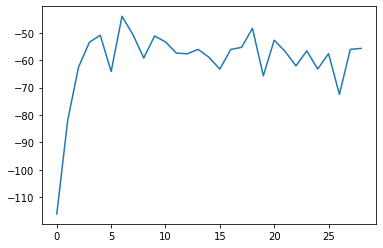

In [0]:
plt.plot(q_success_list)

In [0]:
for i in range(1):
    # Reset environment
    s = env.reset()
    d = False
    j = 0
    env.render()
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        a = np.argmax(Q[s,:])
        s1,r,d,_ = env.step(a)
        s = s1
        #print(s,r)
        env.render()
        if d == True:
            break

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o

## **SARSA**

In [0]:
# 1. Load Environment and Q-table structure
env = CliffWalkingEnv()
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [0]:
# 2. Parameters
alpha = .2
gama = .9
epis = 1500
epsilon = 0.2

rev_list = [] # rewards per episode calculate
sarsa_success_list = []
log_step = 50

Q = np.zeros([env.observation_space.n,env.action_space.n])
print(Q.shape)

(48, 4)


In [0]:
# 3. SARSA Algorithm
for i in range(epis):
    # Reset environment
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    a = np.random.randint(0, env.action_space.n)
    #The Q-Table learning algorithm
    while j < 99:
        #env.render()
        j+=1
        #Get new state & reward from environment
        s1,r,d,_ = env.step(a)
        
        #Pick the next action
        if np.random.uniform() < epsilon:
          a1 = np.random.randint(0, env.action_space.n)
        else:
          a1 = np.argmax(Q[s1,:])
        
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + alpha * ((r + gama* Q[s1,a1]) - Q[s,a])
        rAll += r

        if d == True:
            break
        
        a = a1
        s = s1  
        
    rev_list.append(rAll)
    if i % log_step == 0 and i is not 0:
        success_rate = sum(rev_list[-log_step:]) / log_step
        sarsa_success_list.append(success_rate)

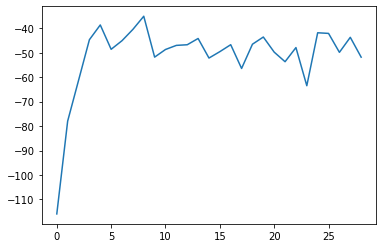

In [0]:
plt.plot(sarsa_success_list)

In [0]:
r_total = 0
for i in range(1):
    # Reset environment
    s = env.reset()
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        a = np.argmax(Q[s,:])
        s1,r,d,_ = env.step(a)
        r_total += r
        s = s1
        env.render()
        if d == True:
            break

print(r_total)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o

## Compare Q-Learning and SARSA


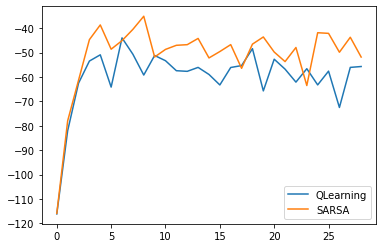

In [0]:
plt.plot(q_success_list, label='QLearning')
plt.plot(sarsa_success_list, label='SARSA')
plt.legend()